<center>
<img src="../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #3. Fall 2018
## <center> Decision trees for classification and regression

**In this assignment, we will find out how a decision tree works in a regression task, then will build and tune classification decision trees for identifying heart diseases.
Fill in the missing code in the cells marked "You code here" and answer the questions in the [web form](https://docs.google.com/forms/d/1hsrNFSiRsvgB27gMbXfQWpq8yzNhLZxuh_VSzRz7XhI).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. A simple example of regression using decision trees

Let's consider the following one-dimensional regression problem. It is needed to build the function $a(x)$ to approximate original dependency $y = f(x)$ using mean-squared error $min \sum_i {(a(x_i) - f(x_i))}^2$.

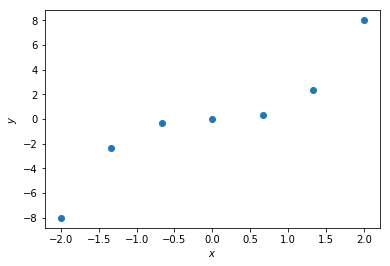

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

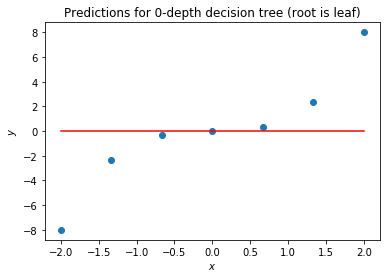

In [3]:
leaf_prediction = X.mean()
y2 = np.full(len(X), leaf_prediction, dtype=float)
plt.title("Predictions for 0-depth decision tree (root is leaf)")
plt.scatter(X, y)
plt.plot(X, y2, color='r')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

Let's make several steps to build the decision tree. Let's choose the symmetric thresholds equal to 0, 1.5 and -1.5 for partitioning. In the case of a regression task, the leaf outputs mean answer for all observations in this leaf.

Let's start from tree of depth 0 that contains all train observations. How will predictions of this tree look like for $x \in [-2, 2]$? Create the appropriate plot using a pen, paper and Python if it is needed (without using `sklearn`).

In [4]:
X.mean()

-6.344131569286608e-17

Let's split the data according to the following condition $[x < 0]$. It gives us the tree of depth 1 with two leaves. Let's create a similar plot for predictions of this tree.

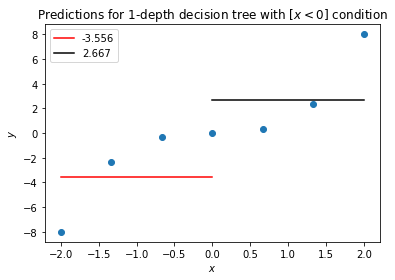

In [5]:
mask = X < 0
mask

left_prediction = np.mean(y[mask])
right_prediction = np.mean(y[~mask])

plt.title(r"Predictions for 1-depth decision tree with $[x < 0]$ condition")
plt.scatter(X, y)
X1 = np.linspace(-2, 0, 10)
y1 = np.full(len(X1), left_prediction, dtype=float)
plt.plot(X1, y1, color='r', label=round(left_prediction, 3))
X2 = np.linspace(0, 2, 10)
y2 = np.full(len(X2), right_prediction, dtype=float)
plt.plot(X2, y2, color='black', label=round(right_prediction, 3))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend(loc='best')

plt.show()

In [6]:
l  = np.array([x for x in X if x < 0])
l.mean()

-1.3333333333333333

In the decision tree algorythm the feature and the threshold for splitting are chosen by some criterion. The commonly used criterion for regression is variance: $$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
where $X$ are observations in this node, $X_l$ and $X_r$ are splits of sample $X$ for two parts by the following criterion $[x_j < t]$ (by $j$-th feature and threshold $t$), $|X|$, $|X_l|$, $|X_r|$ are sizes of approprite samples, and $D(X)$ is the variance of the answers in $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
where $y_i = y(x_i)$ is the answer for $x_i$ observation. Feature $j$ and threshold $t$ are chosen to maximize the value of the functional $Q(X, j, t)$ for each split.

In our case there's only ine feature so $Q$ depends on threshold $t$ (and answers in this node).

Create the plot of the function $Q(X, t)$ in the root depending on the threshold value $t$ on the interval $[-1.9, 1.9]$.

In [7]:
def regression_var_criterion(X, y, t):
    Xl = np.array([x for x in X if x < t])
    Xr = np.array([x for x in X if x >= t])
    result = X.var() - len(Xl)/len(X)*Xl.var() - len(Xr)/len(X)*Xr.var()
    return result

No handles with labels found to put in legend.


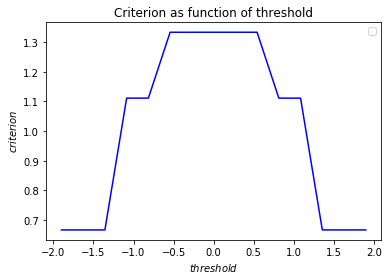

In [8]:
T = np.linspace(-1.9, 1.9, 15)
C = np.array([regression_var_criterion(X, y, t) for t in T])

plt.title(r"Criterion as function of threshold")
plt.plot(T, C, color='b')
plt.xlabel(r'$threshold$')
plt.ylabel(r'$criterion$')
plt.legend(loc='best')

plt.show()

**<font color='red'>Question 1.</font> Is the threshold value $t = 0$ optimal according to the variance criterion?**
- Yes
- No 

Yes

Then let's make splitting in each of the leaves' nodes. In the left branch (where previous split was $x < 0$) using the criterion $[x < -1.5]$, in the right branch (where previous split was $x \geqslant 0$) with the following criterion $[x < 1.5]$. It gives us the tree of depth 2 with 7 nodes and 4 leaves. Create the plot of these tree predictions for $x \in [-2, 2]$.

Prediction values: -8.0 -1.333 0.889 8.0


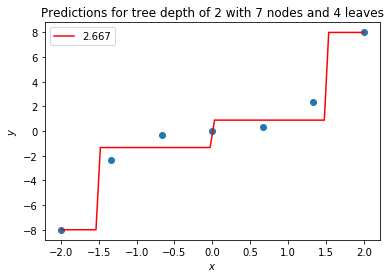

In [9]:
L_mask = X < 0
L_L_mask = X < -1.5
L_R_mask = L_mask & ~L_L_mask
R_mask = ~L_mask
R_R_mask = X >= 1.5
R_L_mask = R_mask & ~R_R_mask

L_L = np.mean(y[L_L_mask])
L_R = np.mean(y[L_R_mask])
R_L = np.mean(y[R_L_mask])
R_R = np.mean(y[R_R_mask])

print('Prediction values:', round(L_L, 3), round(L_R, 3), round(R_L, 3), round(R_R, 3))

space = np.linspace(-2, 2, 70)
predictions = [L_L if x < -1.5 else L_R if x < 0 else R_L if x < 1.5 else R_R for x in space]

plt.title(r"Predictions for tree depth of 2 with 7 nodes and 4 leaves")
plt.scatter(X, y)
plt.plot(space, predictions, color='red', label=round(right_prediction, 3))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend(loc='best')

plt.show()

**<font color='red'>Question 2.</font> How many segments are there on the plot of tree predictions in the interval [-2, 2] (it is necessary to count only horizontal and lines)?**
- 2
- 3
- 4
- 5

Логически: в дереве 4 листа

## 2. Building a decision tree for predicting heart diseases
Let's read the data on heart diseases. 
The dataset can be downloaoded from https://github.com/Yorko/mlcourse.ai/blob/master/data/mlbootcamp5_train.csv by clicking on `Download` and then selecting `Save As` option.

In [10]:
df = pd.read_csv('../data/mlbootcamp5_train.csv', index_col='id', sep=';')

In [11]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Transform the features: create "age in years" (full age) and also create 3 binary features based on `cholesterol` and 3 more on `gluc`, where they are equal to 1, 2 or 3. This method is called dummy-encoding or One Hot Encoding (OHE). It is more convenient to use `pandas.get_dummmies.`. There is no need to use the original features `cholesterol` and `gluc` after encoding.

In [12]:
df["age_in_years"] = df.apply(lambda row: int(row['age']/365), axis=1)

df = pd.concat([df, pd.get_dummies(df['cholesterol'], prefix="cholesterol"),
               pd.get_dummies(df['gluc'], prefix="gluc")], axis=1)

y = df['cardio'].copy()
df.drop(['cholesterol', 'gluc'], axis=1, inplace=True)
X=df

In [13]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_in_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,51,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,47,1,0,0,1,0,0


Split data into train and holdout parts in the proportion of 7/3 using `sklearn.model_selection.train_test_split` with `random_state=17`.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

Train the decision tree on the dataset `(X_train, y_train)` with max depth equals to 3 and `random_state=17`. Plot this tree with `sklearn.tree.export_graphviz`, `dot` and `pydot`. You don't need to use quotes in the file names in order to make it work in a jupyter notebook. The commands starting from the exclamation mark are terminal commands that are usually run in terminal/command line.

In [15]:
clf_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [16]:
import graphviz

In [17]:
dot_clf_tree = export_graphviz(clf_tree, feature_names=df.columns,\
                            out_file=None, filled=True, rounded=True, special_characters=True)
graphviz.Source(dot_clf_tree)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

**<font color='red'>Question 3.</font> What 3 features are used to make predictions in the created decision tree?**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- **age, ap_hi, chol=3**

Make predictions for holdout data `(X_valid, y_valid)` with the trained decision tree. Calculate accuracy.

In [18]:
tree_pred = accuracy_score(y_test, clf_tree.predict(X_test))
print("Train set accuracy: {:.3f}".format(tree_pred))

Train set accuracy: 1.000


Set up the depth of the tree using cross-validation on the dataset `(X_train, y_train)` in order to increase quality of the model. Use `GridSearchCV` with 5 folds. Fix `random_state=17` and change  `max_depth` from 2 to 10.

In [19]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5)

tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Draw the plot to show how mean accuracy is changing in regards to `max_depth` value on cross-validation.

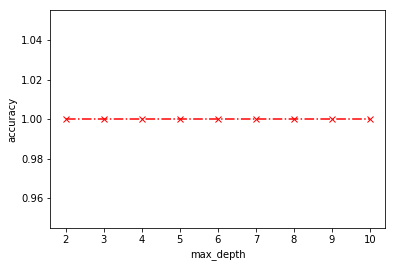

In [20]:
results = tree_grid.cv_results_

plt.xlabel("max_depth")
plt.ylabel("accuracy")

x = results['param_max_depth'].data
y = results['mean_test_score'].data
plt.plot(x, y, linestyle='-.', marker='x', color='red')
plt.show()

Print the best value of `max_depth` where the mean value of cross-validation quality metric reachs maximum. Also compute accuracy on holdout data. All these computations are possible to make using the trained instance of the class `GridSearchCV`.

In [21]:
print("Best params:", tree_grid.best_params_)
print("Best cross validaton score", tree_grid.best_score_)

Best params: {'max_depth': 2}
Best cross validaton score 1.0


**<font color='red'>Question 4.</font> Is there a local maximum of accuracy on the built validation curve? Did `GridSearchCV` help to tune `max_depth` so that there's been at least 1% change in holdout accuracy?**
(check out the expression (acc2 - acc1) / acc1 * 100%, where acc1 and acc2 are accuracies on holdout data before and after tuning `max_depth` with `GridSearchCV` respectively)?
- yes, yes
- **yes, no**
- no, yes
- no, no

In [22]:
acc1 = 0.7212857142857143
acc2 = 0.7321428571428571
(acc2 - acc1) / acc1 * 100

1.5052485640720839

Take a look at the SCORE table to estimate ten-year risk of fatal cardiovascular disease in Europe. [Source paper](https://academic.oup.com/eurheartj/article/24/11/987/427645).

<img src='../img/SCORE2007-eng.png' width=70%>

Create binary features according to this picture:
- $age \in [40,50), \ldots age \in [60,65) $ (4 features)
- systolic blood pressure: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 features)

If the values of age or blood pressure don't fall into any of the intervals then all binary features will be equal to zero. Then we create decision tree with these features and additional ``smoke``, ``cholesterol``  and ``gender`` features. Transform the ``cholesterol`` to 3 binary features according to it's 3 unique values ( ``cholesterol``=1,  ``cholesterol``=2 and  ``cholesterol``=3). This method is called dummy-encoding or One Hot Encoding (OHE). Transform the ``gender`` from 1 and 2 into 0 and 1. It is better to rename it to ``male`` (0 – woman, 1 – man). In general, this is typically done with ``sklearn.preprocessing.LabelEncoder`` but here in case of only 2 unique values it's not necessary.

Finally the decision tree is built using 12 binary features (without original features).

Create a decision tree with the limitation `max_depth=3` and train it on the whole train data. Use the `DecisionTreeClassifier` class with fixed `random_state=17`, but all other arguments (except for `max_depth` and `random_state`) should be set by default.

**<font color='red'>Question 5.</font> What binary feature is the most important for heart disease detection (it is placed in the root of the tree)?**
- Systolic blood pressure from 160 to 180 (mmHg)
- Gender male / female
- **Systolic blood pressure from 140 to 160 (mmHg)**
- Age from 50 to 55 (years)
- Smokes / doesn't smoke
- Age from 60 to 65 (years)

In [24]:
df = pd.read_csv('../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [25]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [27]:
y = df['cardio'].copy()

df2 = pd.DataFrame()

df2['male'] = df['gender'] - 1

years = [(40, 50), (50, 55), (55, 60), (60, 65)]
for low, hi in years:
    df2[f"age_{low}_{hi}"] = ((df['age'] >=low) & (df['age'] < hi)).astype(int)
    
pressure = [(120, 140), (140, 160), (160, 180)]
for ap_min, ap_max in pressure:
    df2[f"ap_hi_{ap_min}_{ap_max}"] = ((df['ap_hi'] >=ap_min) & (df['ap_hi'] < ap_max)).astype(int)
    
df2 = df2.join(df.iloc[:,df.columns.str.startswith('cholesterol').copy()])

df2['smoke'] = df['smoke'].copy()

df2.shape, y.shape

((70000, 10), (70000,))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df2, df['cardio'], test_size=0.3, random_state=17)
heart_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
heart_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [29]:
dot_data = export_graphviz(heart_tree, feature_names=X_train.columns, out_file=None, filled=True)
graph = graphviz.Source(dot_data)
graph

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH